# Import Dataset From Kaggle

###Import Kaggle JSON

In [24]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


###Import Dataset and Unzip

In [25]:
!kaggle datasets download -d cfchan/daily-usdjpy-20002019-with-technical-indicators
!unzip "/content/daily-usdjpy-20002019-with-technical-indicators.zip"

daily-usdjpy-20002019-with-technical-indicators.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/daily-usdjpy-20002019-with-technical-indicators.zip
replace Column_Description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace USDJPY_Daily.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


#Import Library

In [26]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

#Membaca Data

In [27]:
df = pd.read_csv('/content/USDJPY_Daily.csv')
df.head()

,date,open,high,low,close,open1,high1,low1,close1,open2,high2,low2,close2,open3,high3,low3,close3,open4,high4,low4,close4,open5,high5,low5,close5,macd0,signal0,diff0,macd1,signal1,diff1,macd2,signal2,diff2,macd3,signal3,diff3,macd4,signal4,diff4,macd5,signal5,diff5,rsi0,rsi1,rsi2,rsi3,rsi4,rsi5,dn0,mavg0,up0,pctB0,dn1,mavg1,up1,pctB1,dn2,mavg2,up2,pctB2,dn3,mavg3,up3,pctB3,dn4,mavg4,up4,pctB4,dn5,mavg5,up5,pctB5,target1,target2
0,2000-07-13,108.23,108.56,107.00,108.35,107.20,108.51,107.14,108.24,107.07,107.43,106.65,107.19,107.40,107.44,106.69,107.06,107.90,107.92,107.39,107.41,107.66,107.98,107.30,107.94,0.772167,0.133339,0.638828,0.608825,-0.022304,0.631129,0.401757,-0.171717,0.573474,0.281041,-0.305271,0.586312,0.170916,-0.429937,0.600853,-0.007369,-0.537188,0.529820,72.508039,70.512821,70.747218,67.711599,71.875000,71.993410,103.967806,106.3275,108.687194,0.928551,103.991662,106.1845,108.377338,0.968685,104.076844,106.0610,108.045156,0.784504,104.095601,106.0140,107.932399,0.772623,104.113807,105.9830,107.852193,0.881715,104.167185,105.9395,107.711815,1.064375,12.0,Green
1,2000-07-14,108.36,108.48,107.59,107.87,108.23,108.56,107.00,108.35,107.20,108.51,107.14,108.24,107.07,107.43,106.65,107.19,107.40,107.44,106.69,107.06,107.90,107.92,107.39,107.41,0.870432,0.286105,0.584327,0.772167,0.133339,0.638828,0.608825,-0.022304,0.631129,0.401757,-0.171717,0.573474,0.281041,-0.305271,0.586312,0.170916,-0.429937,0.600853,73.692810,72.508039,70.512821,70.747218,67.711599,71.875000,104.059010,106.4575,108.855990,0.794456,103.967806,106.3275,108.687194,0.928551,103.991662,106.1845,108.377338,0.968685,104.076844,106.0610,108.045156,0.784504,104.095601,106.0140,107.932399,0.772623,104.113807,105.9830,107.852193,0.881715,-49.0,Red
2,2000-07-16,107.52,108.28,107.49,108.14,108.36,108.48,107.59,107.87,108.23,108.56,107.00,108.35,107.20,108.51,107.14,108.24,107.07,107.43,106.65,107.19,107.40,107.44,106.69,107.06,0.981260,0.433815,0.547445,0.870432,0.286105,0.584327,0.772167,0.133339,0.638828,0.608825,-0.022304,0.631129,0.401757,-0.171717,0.573474,0.281041,-0.305271,0.586312,72.193437,73.692810,72.508039,70.512821,70.747218,67.711599,104.256160,106.6270,108.997840,0.819085,104.059010,106.4575,108.855990,0.794456,103.967806,106.3275,108.687194,0.928551,103.991662,106.1845,108.377338,0.968685,104.076844,106.0610,108.045156,0.784504,104.095601,106.0140,107.932399,0.772623,62.0,Green
3,2000-07-17,108.15,108.83,107.81,108.06,107.52,108.28,107.49,108.14,108.36,108.48,107.59,107.87,108.23,108.56,107.00,108.35,107.20,108.51,107.14,108.24,107.07,107.43,106.65,107.19,1.058356,0.570821,0.487535,0.981260,0.433815,0.547445,0.870432,0.286105,0.584327,0.772167,0.133339,0.638828,0.608825,-0.022304,0.631129,0.401757,-0.171717,0.573474,68.761553,72.193437,73.692810,72.508039,70.512821,70.747218,104.497028,106.7900,109.082972,0.776933,104.256160,106.6270,108.997840,0.819085,104.059010,106.4575,108.855990,0.794456,103.967806,106.3275,108.687194,0.928551,103.991662,106.1845,108.377338,0.968685,104.076844,106.0610,108.045156,0.784504,-9.0,Red
4,2000-07-18,108.06,108.47,107.65,108.20,108.15,108.83,107.81,108.06,107.52,108.28,107.49,108.14,108.36,108.48,107.59,107.87,108.23,108.56,107.00,108.35,107.20,108.51,107.14,108.24,1.149907,0.699407,0.450500,1.058356,0.570821,0.487535,0.981260,0.433815,0.547445,0.870432,0.286105,0.584327,0.772167,0.133339,0.638828,0.608825,-0.022304,0.631129,70.181818,68.761553,72.193437,73.692810,72.508039,70.512821,104.838519,106.9710,109.103481,0.788162,104.497028,106.7900,109.082972,0.776933,104.256160,106.6270,108.997840,0.819085,104.059010,106.4575,108.855990,0.794456,103.967806,106.3275,108.687194,0.928551,103.991662,106.1845,108.377338,0.968685,14.0,Green


In [28]:
print("jumlah data = {}\n".format(df.shape[0]))
df.isnull().sum()

jumlah data = 5757



date       0
open       0
high       0
low        0
close      0
          ..
mavg5      0
up5        0
pctB5      0
target1    0
target2    0
Length: 75, dtype: int64

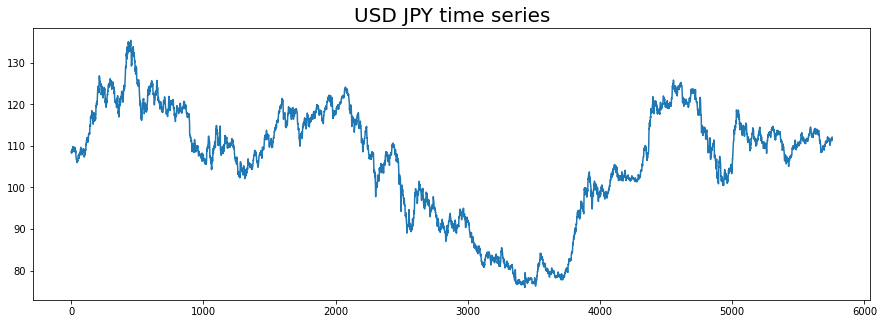

In [29]:
data_usd_jpy = df.iloc[:, 2:3].values

plt.figure(figsize=(15,5))
plt.plot(data_usd_jpy)
plt.title('USD JPY time series',
          fontsize=20);

#Pra-pemrosesan

##Membagi dataset
- 5000 data dilakukan pembagian dengan 80% untuk training dan 20% untuk validasi
- 757 data digunakan untuk testing

In [30]:
data_train_val = data_usd_jpy[:5000] #data train dan validasi
data_test = data_usd_jpy[5000-60:] #data test dengan mengambil 60 data sebelumnya
data_test_asli = data_usd_jpy[5000:] #data test asli

dataTrain = data_train_val[:len(data_train_val)-int(len(data_train_val)*0.2),]
dataVal = data_train_val[len(data_train_val)-int(len(data_train_val)*0.2)-60:,]
dataTest = data_test

print(dataTrain.shape)
print(dataVal.shape)
print(dataTest.shape)

(4000, 1)
(1060, 1)
(817, 1)


##Transform Data

In [31]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(dataTrain)
val_scaled = sc.fit_transform(dataVal)
print(train_scaled.shape, val_scaled.shape)

(4000, 1) (1060, 1)


##Pengamatan: menggunakan 60 data sebelumnya (interval) untuk menghitung nilai prediksi

In [32]:
def get_scaled_data(interval, data):
    X, Y = [], []
    for i in range(interval, len(data)):
        X.append(data[i-interval:i, 0])
        Y.append(data[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, Y

In [33]:
X_train, y_train = get_scaled_data(60, train_scaled)
X_val, y_val = get_scaled_data(60, val_scaled)

#Model LSTM

In [34]:
LSTM_model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(units=50),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=1)
])

In [35]:
LSTM_model.compile(loss= 'mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999),
              metrics=['accuracy'])

mcp_save = tf.keras.callbacks.ModelCheckpoint("best_model.hdf5", monitor='loss', mode='min', verbose=1)

history = LSTM_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), 
                         verbose=1, callbacks=[mcp_save])

Epoch 1/50
58/62 [===========================>..] - ETA: 0s - loss: 0.0287 - accuracy: 5.3879e-04
Epoch 00001: saving model to best_model.hdf5
62/62 [==============================] - 1s 21ms/step - loss: 0.0272 - accuracy: 5.0761e-04 - val_loss: 0.0015 - val_accuracy: 0.0010
Epoch 2/50
59/62 [===========================>..] - ETA: 0s - loss: 0.0025 - accuracy: 5.2966e-04
Epoch 00002: saving model to best_model.hdf5
62/62 [==============================] - 1s 10ms/step - loss: 0.0024 - accuracy: 5.0761e-04 - val_loss: 0.0021 - val_accuracy: 0.0010
Epoch 3/50
60/62 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 5.2083e-04
Epoch 00003: saving model to best_model.hdf5
62/62 [==============================] - 1s 10ms/step - loss: 0.0021 - accuracy: 5.0761e-04 - val_loss: 0.0024 - val_accuracy: 0.0010
Epoch 4/50
59/62 [===========================>..] - ETA: 0s - loss: 0.0018 - accuracy: 5.2966e-04
Epoch 00004: saving model to best_model.hdf5
62/62 [===================

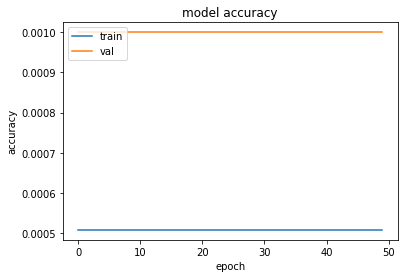

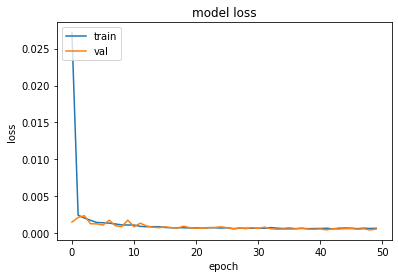

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Prediksi

In [37]:
dataTest_sc = sc.transform(dataTest)
print(dataTest_sc.shape)

(817, 1)


In [38]:
X_test = []

for i in range(60, len(dataTest_sc)):
    X_test.append(dataTest_sc[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_test.shape)

(757, 60, 1)


In [39]:
prediksi = LSTM_model.predict(X_test)
prediksi = sc.inverse_transform(prediksi)

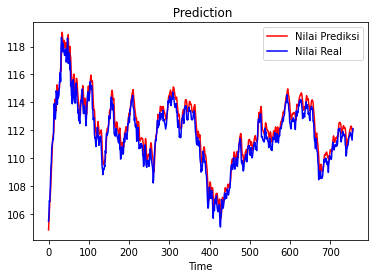

In [40]:
plt.plot(prediksi,"r",label="Nilai Prediksi")
plt.plot(data_test_asli,"b",label="Nilai Real")
plt.legend()
plt.title(' Prediction')
plt.xlabel('Time')
plt.show()

# MAE

In [41]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(data_test_asli, prediksi)
print(mae)

0.5826031818263911


In [42]:
maxData = max(data_usd_jpy)
minData = min(data_usd_jpy)
MAE = (maxData - minData) * 0.1
print(maxData, minData, MAE)

[135.4] [75.93] [5.947]
